In [1]:
import os
import matplotlib.pyplot as plt
import h5py
import phase_contrast as pc
from pathlib import Path
import numpy as np
from PIL import Image

In [2]:
SCRIPT_PATH = os.getcwd()
PHANTOM_DB_FOLDER_NAME = 'database'
TXT_FOULDER_NAME = 'txt_files'
FILE_ID = '123493'
TXT_FILE_NAME = f'diamond {FILE_ID}.txt'

In [3]:
def get_img(file_name):
    file_path = os.path.join(SCRIPT_PATH, PHANTOM_DB_FOLDER_NAME, file_name)

    with h5py.File(file_path, 'r') as hdf:
        dataset = hdf.get(name = file_name)
        dataset = dataset[()]
    return dataset

In [154]:
def get_2d_slice(num):
    data_folder = '/nfs/synology-tomodata/external_data/tomo/Diamond/I13'+\
                    f'/2020_02/recon/{FILE_ID}/full_recon/20200206101055_123493/TiffSaver-tomo'

    file_names = Path(data_folder).glob('*.tiff')
    file_names = list(file_names)
    img2d_gray = img2d = np.array(Image.open(file_names[num]))

    return img2d_gray

In [5]:
def write_dict_to_file(dict):
    for key, value in dict.items():
        write_item_to_file(key, value)


def write_item_to_file(key, value):
    db_folder = os.path.join(SCRIPT_PATH, TXT_FOULDER_NAME)
    if not os.path.isdir(db_folder):
        os.mkdir(db_folder)

    file_path = os.path.join(SCRIPT_PATH, TXT_FOULDER_NAME, TXT_FILE_NAME)
    file_txt = open(file_path,"a")
    file_txt.write(f"{key} {value} \n")
    file_txt.close()


In [28]:
k_dictionary ={}

2120


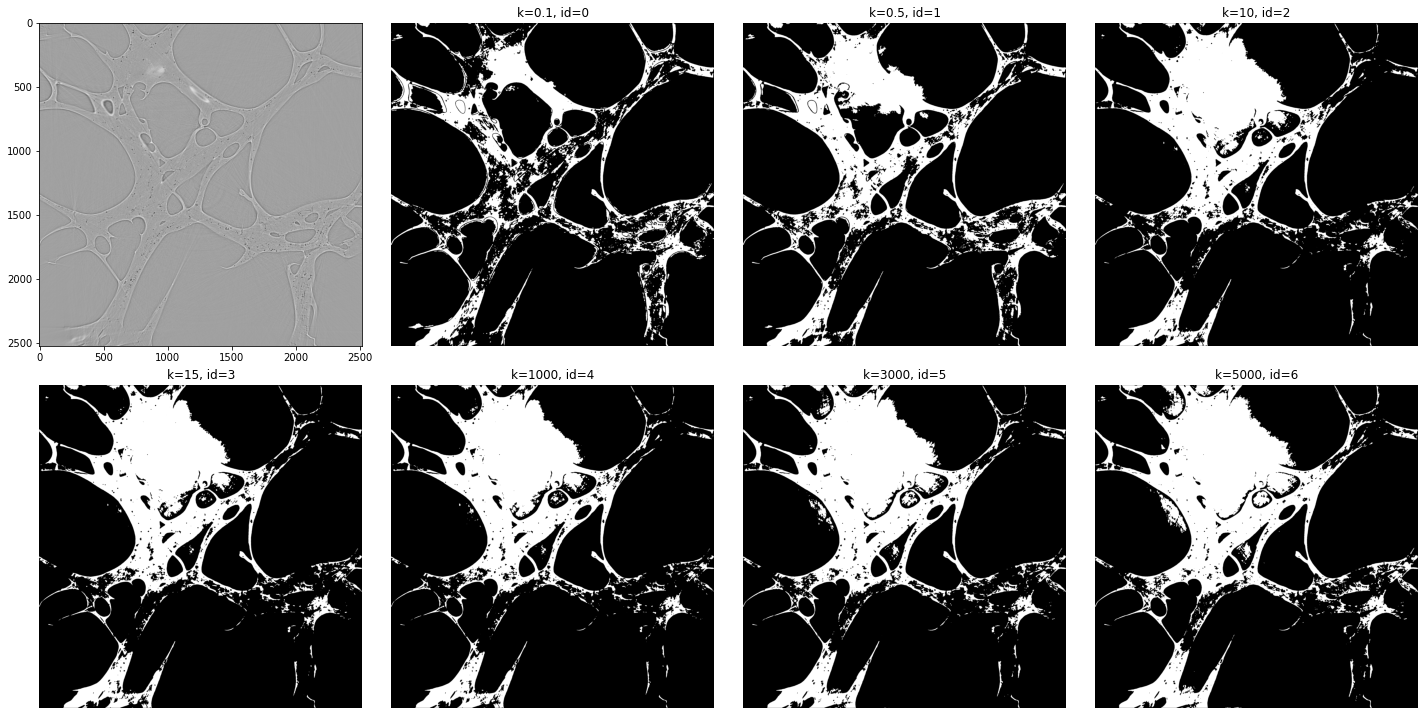

In [153]:
#k_possible_values = [1/10, 1/20, 1/80, 1/100, 1/130, 1/500, 1/300]
k_possible_values = [1/10, 1/2, 10, 15, 1000, 3000, 5000]
slice_num = 2119
k = k_possible_values[0]

img2d_gray = get_2d_slice(slice_num)
fig, axes = plt.subplots(2, 4, figsize=(20,10))

axes = axes.ravel()
axes[0].imshow(img2d_gray, cmap='gray')

for i, k in enumerate(k_possible_values):
    axes[i+1].imshow(pc.binarize_slice(img2d_gray, k=k, mu=25e-8), cmap='gray')
    axes[i+1].set_title(f"k={k}, id={i}")
    axes[i+1].axis("off")

plt.tight_layout()

In [155]:
id = 1
k_dictionary.update({f"{slice_num}": k_possible_values[id]})

In [156]:
#k_dictionary = {'750': 500, '780': 0.5, '810': 20, '840': 20, '870': 15}
k_dictionary

{'2119': 0.5}

In [157]:
# backup
write_dict_to_file(k_dictionary)
k_dictionary = {}

# Read from file

Text(0.5, 0, 'номер слоя')

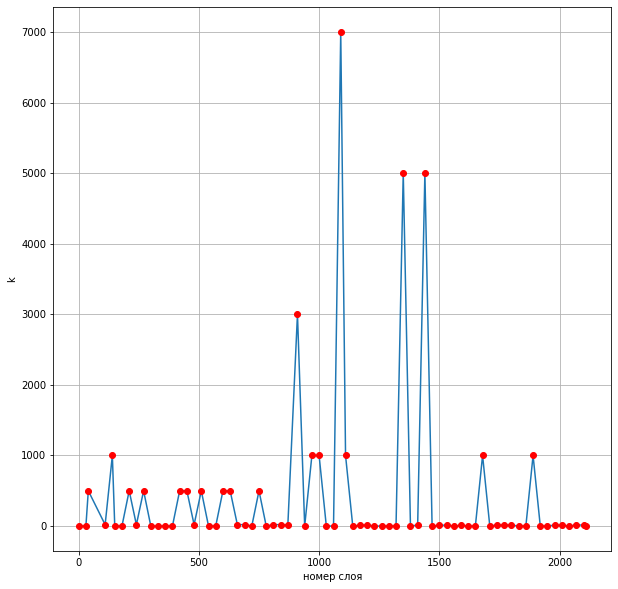

In [256]:
db_folder = os.path.join(SCRIPT_PATH, TXT_FOULDER_NAME, TXT_FILE_NAME)
file = open(db_folder, 'r')

indexes_of_slices = []
k_values = []
for line in file:
    z, k = line.split()
    z, k = np.int(z), np.float32(k)
    k_values.append(k)
    indexes_of_slices.append(z)

plt.figure(figsize=(10,10))
plt.plot(indexes_of_slices, k_values)
plt.grid()

plt.plot(indexes_of_slices, k_values, 'o', color='red')
plt.ylabel('k')
#plt.yscale('log')
plt.xlabel('номер слоя')


In [270]:
from scipy.interpolate import interp1d

f = interp1d(x, y, kind='nearest')
n = 10
x = [0, 4, 9]
y = [30, 2, 1]
mask_y = np.zeros(n, dtype=int)
#mask_x = np.arrange(n, dtype=int)
mask_y[x] = y

xnew = np.arange(0, n, 1)
f(xnew)


array([30., 30., 30.,  2.,  2.,  2.,  2.,  1.,  1.,  1.])

# RESULTS

819

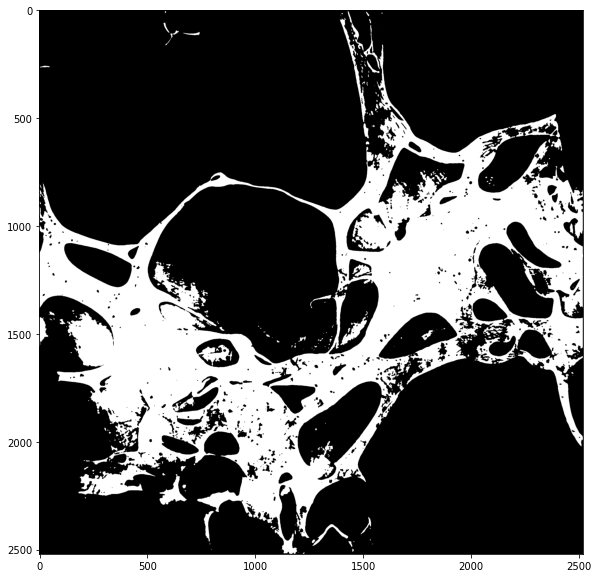

In [271]:
data_folder = '/nfs/synology-tomodata/external_data/tomo/Diamond/I13'+\
                '/2020_02/recon/123495/full_recon/20200206141126_123495/TiffSaver-tomo'


num = np.random.randint(0,2120)
img3d = get_img(f'bin_img.h5')
fig, axes = plt.subplots(figsize=(10,10))
axes.imshow(img3d[num], cmap='gray')
num

1800

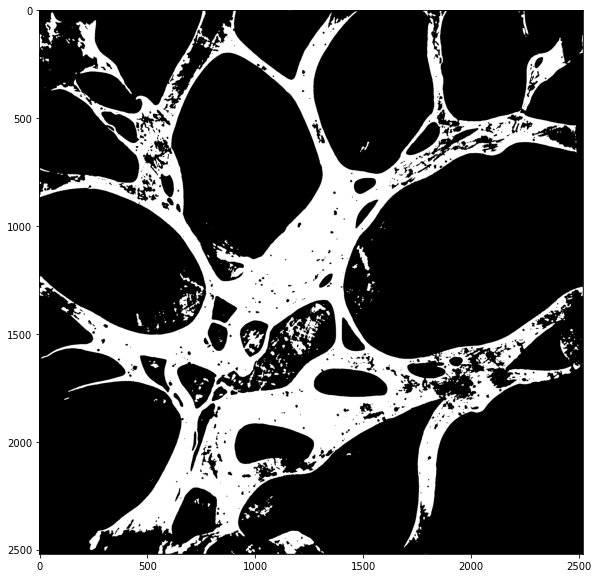

In [284]:
num = np.random.randint(0,2120)
fig, axes = plt.subplots(figsize=(10,10))
axes.imshow(img3d[num], cmap='gray')
num

In [273]:
x, y, z = img3d.shape
volume = x*y*z
volume

13462848000

In [276]:
np.sum(img3d) / volume

0.2508078745299657

# TRIAL TO OPTIMIZE THE ALGORITHM

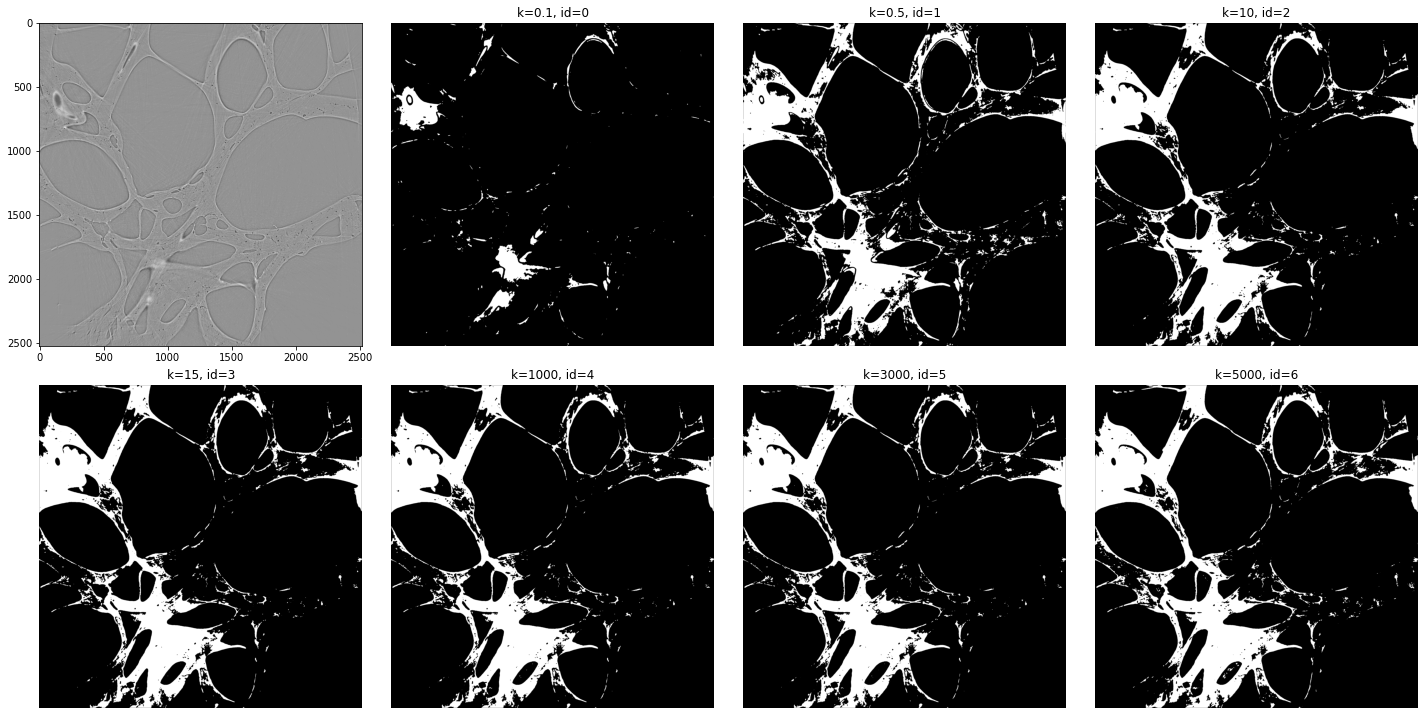

In [8]:

k_possible_values = [1/10, 1/2, 10, 15, 1000, 3000, 5000]
slice_num = 1090
k = k_possible_values[0]

img2d_gray = get_2d_slice(slice_num)
fig, axes = plt.subplots(2, 4, figsize=(20,10))

axes = axes.ravel()
axes[0].imshow(img2d_gray, cmap='gray')

for i, k in enumerate(k_possible_values):
    axes[i+1].imshow(pc.binarize_slice(img2d_gray, k=k, mu=25e-8), cmap='gray')
    axes[i+1].set_title(f"k={k}, id={i}")
    axes[i+1].axis("off")

plt.tight_layout()

In [13]:
data_fft = np.fft.fft2(img2d_gray)

def get_fft_section(slice_num):
    img2d_gray = get_2d_slice(slice_num)
    freq = np.fft.fftshift(np.abs(np.fft.fft2(img2d_gray)))
    return freq[freq.shape[0]//2]

def get_corr_section(slice_num, k):
    img2d_gray = get_2d_slice(slice_num)
    freq = np.fft.fftshift(np.fft.fftfreq(img2d_gray.shape[0]))
    fx, fy = np.meshgrid(freq, freq)
    f2 = np.sqrt(fx**2+fy**2)[freq.shape[0]//2]
    mu=25e-8
    return 1/np.sqrt(k * f2**2 + mu)


#plt.hist(f2[f2.shape[0]//2], bins = 200)
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(get_f2_section(slice_num=1090), label='1090')
#ax.plot(get_corr_section(slice_num=1090, k=3000), label='corr 1090')
ax.plot(get_f2_section(slice_num=750), label='750')
#ax.plot(get_corr_section(slice_num=750, k=1), label='corr 750')
ax.legend()
ax.grid()

NameError: name 'get_f2_section' is not defined

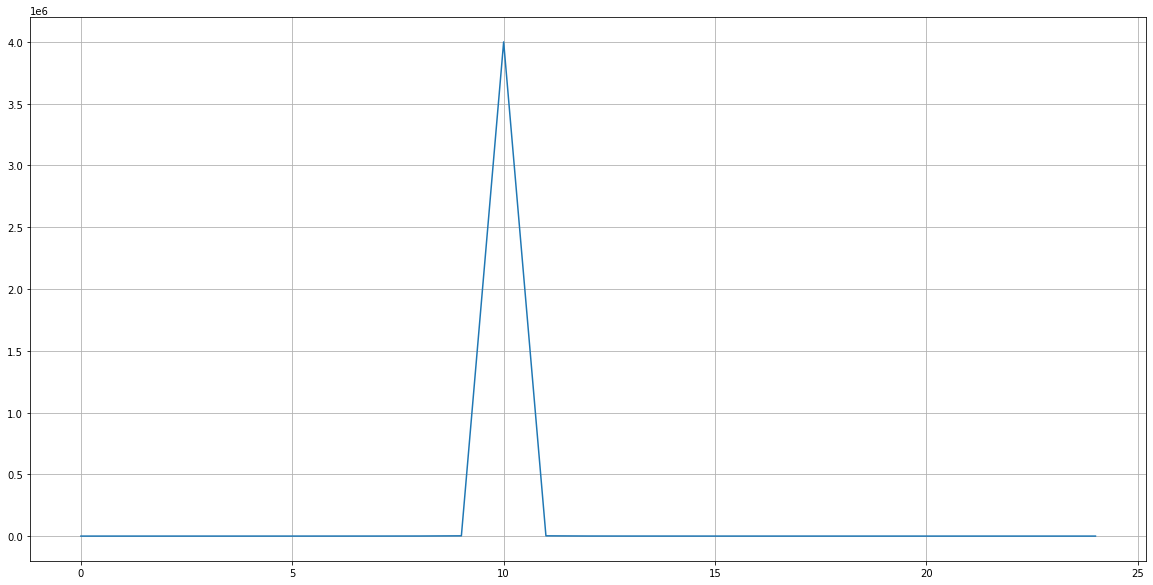

In [44]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(get_corr_section(slice_num=750, k=3000)[1250:1275], label='corr 750')
#ax.plot(get_corr_section(slice_num=750, k=500)[1250:1275], label='corr 750')
ax.grid()


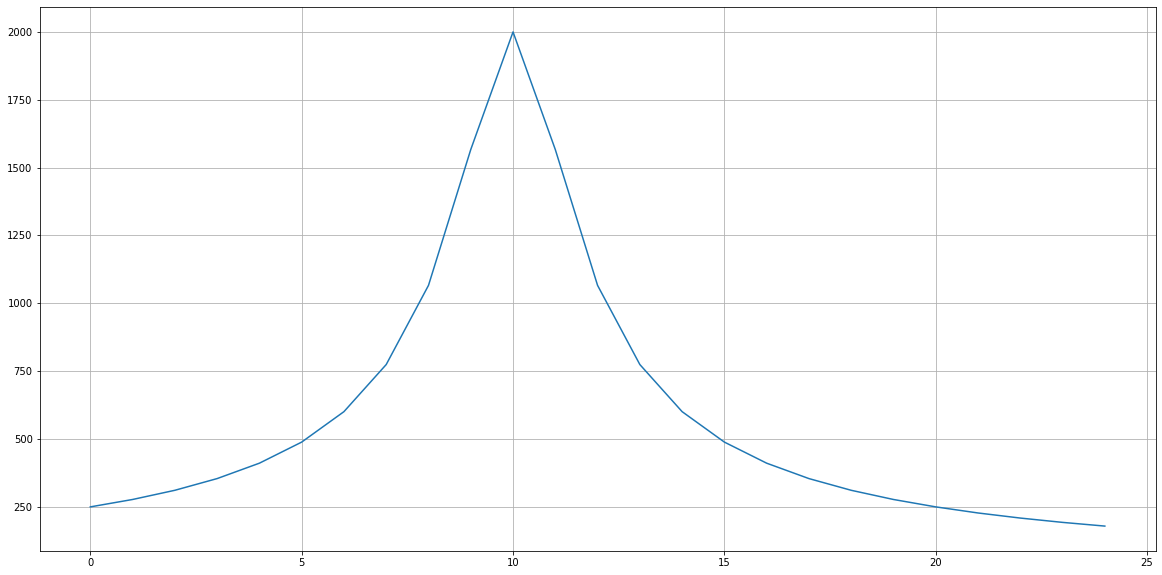

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(get_corr_section(slice_num=750, k=1)[1250:1275], label='corr 750')
ax.grid()
